# Utilities

In [ ]:
#| default_exp util
import jax
jax.config.update("jax_enable_x64", True)

In [ ]:
#| export
import jax.numpy as jnp
from jax import vmap
from jaxtyping import Array, Float, Bool
import tensorflow_probability.substrates.jax as tfp
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalLinearOperator as MVNLO


In [ ]:
import jax

In [ ]:
jax.config.update("jax_enable_x64", True)

## sampling from degenerate Multivariate normal

The `MultivariateNormalFullCovariance` distribution from `tfp` only supports non-singular covariance matrices for sampling, because internally a Cholesky decomposition is used, which is ambiguous for singular symmetric matrices. Instead, we use an eigenvalue decomposition, and compute a valid Cholesky root by QR-decomposition.

In [ ]:
#| export
LOFM = tfp.tf2jax.linalg.LinearOperatorFullMatrix
LOLT = tfp.tf2jax.linalg.LinearOperatorLowerTriangular
def degenerate_cholesky(Sigma): 
    evals, evecs = jnp.linalg.eigh(Sigma)
    # transpose for QR
    # ensure positive eigenvalues
    sqrt_cov = jnp.einsum('...ij,...j->...ji', evecs, jnp.sqrt(jnp.abs(evals)))
    Q, R = jnp.linalg.qr(sqrt_cov, mode='complete')
    # ensure positive diagonal
    R = R * jnp.sign(jnp.einsum('...ii->...i', R)[..., None])
    L = R.swapaxes(-1, -2)
    return L

def MVN_degenerate(loc: Array, cov: Array) -> tfp.distributions.MultivariateNormalLinearOperator:
    L = degenerate_cholesky(cov)
    return MVNLO(loc=loc, scale=LOLT(L))

In [ ]:
import jax.random as jrn
import matplotlib.pyplot as plt
import fastcore.test as fct

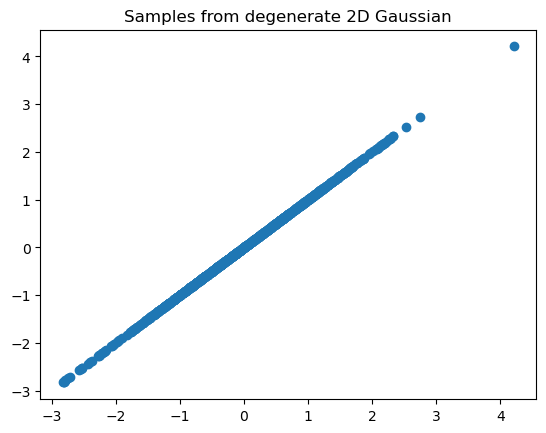

In [ ]:
mu = jnp.zeros(2)
Sigma = jnp.array([[1., 1.], [1., 1.]])

N = 1000
samples = MVN_degenerate(mu, Sigma).sample(seed=jrn.PRNGKey(0), sample_shape=(N,))
plt.title("Samples from degenerate 2D Gaussian")
plt.scatter(samples[:, 0], samples[:, 1])
plt.show()

fct.test_close(samples @ jnp.array([[1.], [-1.]]), jnp.zeros(N))

## optimization

In [ ]:
# | export
def converged(
    new: Float[Array, "..."],  # the new array
    old: Float[Array, "..."],  # the old array
    eps: Float,  # tolerance
) -> Bool:  # whether the arrays are close enough
    """check that sup-norm of relative change is smaller than tolerance"""
    is_close = jnp.max(jnp.abs((new - old) / old)) < eps
    any_nans = jnp.isnan(new).sum() > 0
    return jnp.logical_or(is_close, any_nans)

## vmapped utilities

In [ ]:
#| export

# matmul with $A_t$ and $X^i_t$
mm_sim = vmap(jnp.matmul, (None, 0))
# matmul with $(A_t)_{t}$ and $(X_t)_{t}$
mm_time = vmap(jnp.matmul, (0, 0))
# matmul with $(A_t)_{t}$ and $(X^i_t)_{i,t}$
mm_time_sim = vmap(mm_time, (None, 0))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()